In [4]:
import kagglehub
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import textstat

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

C:\Users\ronak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ronak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

# load datasets
df=pd.read_csv(path+'/WELFake_Dataset.csv')
df.head()

Path to dataset files: C:\Users\ronak\.cache\kagglehub\datasets\saurabhshahane\fake-news-classification\versions\77


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
df.shape

(72134, 4)

In [8]:
df['article'] = df['title'] + df['text']
df = df[['article', 'label']]
df.head()

,article,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,NaN,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,1


In [9]:
df.dropna(inplace=True)
df.drop_duplicates(subset='article', inplace=True)
df.shape

(63121, 2)

In [10]:
df['sentiment_polarity'] = df['article'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['article'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [11]:
df.head()

,article,label,sentiment_polarity,sentiment_subjectivity
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,0.034641,0.296824
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,0.190402,0.512798
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0,0.111493,0.387106
4,SATAN 2: Russia unvelis an image of its terrif...,1,0.013342,0.403577
5,About Time! Christian Group Sues Amazon and SP...,1,-0.100461,0.428571


In [12]:
df['word_count'] = df['article'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['article'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)
df['sentence_count'] = df['article'].apply(lambda x: len(str(x).split('.')))
df['unique_word_count'] = df['article'].apply(lambda x: len(set(str(x).split())) / len(str(x).split()))


In [13]:
df['flesch_reading_ease'] = df['article'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df['exclamation_count'] = df['article'].apply(lambda x: str(x).count('!'))
df['question_count'] = df['article'].apply(lambda x: str(x).count('?'))

In [14]:
df.head()

,article,label,sentiment_polarity,sentiment_subjectivity,word_count,char_count,avg_word_length,sentence_count,unique_word_count,flesch_reading_ease,exclamation_count,question_count
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,0.034641,0.296824,888,5179,5.825647,55,0.494369,72.56,2,7
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,0.190402,0.512798,52,353,6.660377,2,0.942308,45.09,1,0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",0,0.111493,0.387106,1336,8115,6.069559,61,0.520210,56.59,0,1
4,SATAN 2: Russia unvelis an image of its terrif...,1,0.013342,0.403577,344,2011,5.828986,12,0.584302,51.21,0,0
5,About Time! Christian Group Sues Amazon and SP...,1,-0.100461,0.428571,256,1608,6.256809,12,0.648438,59.94,2,0


# preprocessing

In [ ]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    text = re.sub(r'\b([a-zA-Z])\.(?=[a-zA-Z])', r'\1specialdot', text)  # Preserve acronyms
    text = re.sub(r'\b([a-zA-Z])\.(?=\s|$)', r'\1specialdot', text)
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.replace("specialdot", ".")
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    stop_words.discard("not")
    stop_words.discard("no")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Vectorize text
def vectorize(text, maxFeats, ngram):
    vectorizer = TfidfVectorizer(max_features=maxFeats, ngram_range=ngram, stop_words='english')
    X_tfidf = vectorizer.fit_transform(text)
    return X_tfidf, vectorizer

# Load data
X_train, X_test, y_train, y_test = train_test_split(
    df[['article','sentiment_polarity','sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']], df['label'], 
    test_size=0.2, random_state=42, stratify=df['label']
)

# Preprocess data
X_train_processed = X_train['article'].apply(preprocess_text)
X_test_processed = X_test['article'].apply(preprocess_text)

# Vectorize data
X_train_vectorized, vectorizer = vectorize(X_train_processed, 2000, (1,1))
X_test_vectorized = vectorizer.transform(X_test_processed)


In [16]:
train_vectorized_df = pd.DataFrame(X_train_vectorized)
X_train_df = pd.concat([train_vectorized_df.reset_index(drop=True), X_train[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']].reset_index(drop=True)], axis=1)
test_vectorized_df = pd.DataFrame(X_test_vectorized)
X_test_df = pd.concat([test_vectorized_df.reset_index(drop=True), X_test[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']].reset_index(drop=True)], axis=1)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [18]:
from scipy.sparse import vstack

### **What Are Neural Networks (NN)?**

Neural Networks (NN) are computational models inspired by the structure and function of the human brain. They are a subset of machine learning algorithms designed to recognize patterns, process data, and make predictions or decisions. Neural networks consist of layers of interconnected nodes (neurons), where each node mimics the behavior of a biological neuron by processing inputs and producing outputs based on an activation function.

---

### **Components of a Neural Network**

1. **Input Layer**:
   - Takes raw data as input and passes it to the subsequent layers.

2. **Hidden Layers**:
   - Perform intermediate computations by applying weights, biases, and activation functions.
   - The depth (number of layers) and width (number of neurons per layer) determine the model's capacity to learn complex patterns.

3. **Output Layer**:
   - Produces the final predictions or classifications based on the processed data.

4. **Weights and Biases**:
   - Weights determine the strength of connections between neurons.
   - Biases help shift the activation function to better fit the data.

5. **Activation Functions**:
   - Introduce non-linearity to the model, allowing it to learn complex relationships.
   - Examples: ReLU, Sigmoid, Tanh, and Softmax.

---

### **Why Are Neural Networks Good?**


#### **1. Ability to Learn Complex Non-Linear Relationships**
- Neural networks can model highly non-linear and complex patterns in data, which traditional algorithms might struggle with.
- Through multiple layers of non-linear transformations, they can capture intricate features and dependencies.

---


#### **4. Feature Learning**
- Traditional algorithms often require handcrafted features. Neural networks learn features automatically from raw data, reducing the need for manual feature engineering.



#### **6. Handling Unstructured Data**
- Neural networks can process unstructured data types like images, audio, and text effectively, making them indispensable in fields like computer vision and NLP.

---





In [19]:
train_sparse_matrix = vstack(X_train_df.iloc[:,0])
train_dense_array = train_sparse_matrix.toarray()
train_tensor_dense_array = torch.tensor(train_dense_array,dtype=torch.float32)

train_numeric_df = X_train_df[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']]
train_data_array = train_numeric_df.to_numpy()
train_data_tensor = torch.tensor(train_data_array,dtype=torch.float32)
## Need to add train_data_tensor to the end of train_tensor_dense_array

train_combined_tensor = torch.cat([train_tensor_dense_array,train_data_tensor],dim=1)


test_sparse_matric = vstack(X_test_df.iloc[:,0])
test_dense_array = test_sparse_matric.toarray()
test_tensor_dense_array = torch.tensor(test_dense_array,dtype=torch.float32)

test_numeric_df = X_test_df[['sentiment_polarity', 'sentiment_subjectivity','word_count','char_count','avg_word_length','sentence_count','unique_word_count','flesch_reading_ease','exclamation_count','question_count']]
test_data_array = test_numeric_df.to_numpy()
test_data_tensor = torch.tensor(test_data_array,dtype=torch.float32)

test_combined_tensor = torch.cat([test_tensor_dense_array,test_data_tensor], dim=1)




y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)



Adam combines two key techniques:

Momentum (from SGD with Momentum): Uses an exponentially decaying average of past gradients to smooth updates, helping to accelerate convergence, especially in noisy or high-curvature regions.
Adaptive Learning Rates (from AdaGrad/RMSProp): Scales each parameter's learning rate based on the square root of past squared gradients. This helps adjust learning rates dynamically for different parameters.


In [20]:
import matplotlib.pyplot as plt


In neural networks (NN), dropout is a regularization technique designed to prevent overfitting. It works by randomly "dropping out" (i.e., setting to zero) a fraction of the neurons in a layer during each training iteration. This means that these neurons are temporarily ignored, including their connections, during both the forward and backward passes.

Purpose of Dropout
The primary purpose of dropout is to improve the generalization of the model by reducing overfitting. Here's how it achieves this:

Preventing Co-Adaptation: Dropout forces the network to not overly rely on specific neurons since any neuron could be dropped out during training. This encourages the network to learn more robust and distributed representations.

Introducing Noise: By randomly removing neurons, dropout introduces noise into the training process. This helps the model become more resilient to variations in the input data.

Simulating an Ensemble of Networks: Each dropout iteration effectively trains a different "thinned" version of the neural network. At test time, when dropout is disabled, the full network acts as an approximate ensemble of all these smaller networks, improving performance.

In [ ]:

# Create DataLoader for batching
train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

def accuracy_score(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            predictions = (outputs >= 0.5).float()
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()
    return (correct / total)

# Define the neural network
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Initialize the model
input_dim = train_combined_tensor.shape[1]
model = FakeNewsClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epoch_levels = [5,10,15,20,30]
accuracy_values =  []


for epochs in epoch_levels:
    model = FakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    accuracy = accuracy_score(model, test_loader)
    accuracy_values.append(accuracy)


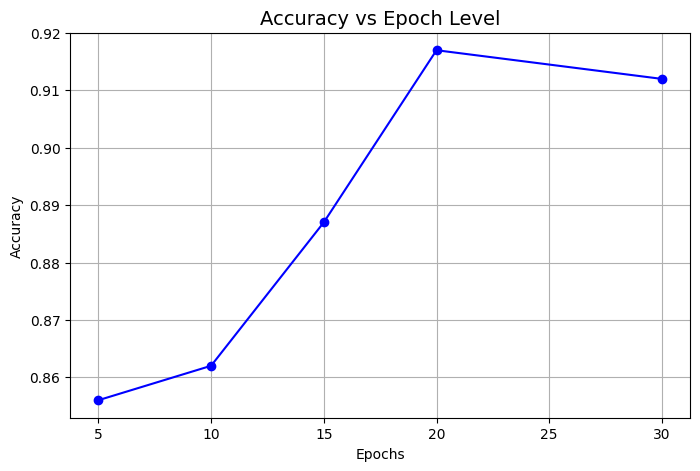

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(epoch_levels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Epoch Levels')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Batch Normalization is a technique in deep learning designed to stabilize and accelerate the training process of neural networks. It normalizes the input of each layer in a network to have a mean of zero and a variance of one, improving the convergence of the model. This normalization is applied during training as part of the forward pass.


Accelerate Training: By normalizing the inputs to each layer, batch normalization reduces the internal covariate shift, which refers to changes in the distribution of layer inputs as the network parameters are updated. This leads to faster convergence.

Reduce Sensitivity to Initialization: Proper weight initialization is less critical when batch normalization is used, as the network learns normalized representations dynamically.

Improve Generalization: Batch normalization acts as a form of regularization by introducing small stochastic noise during training, reducing overfitting. This can sometimes reduce the need for other forms of regularization like dropout.

Higher Learning Rates: With normalized inputs, the network can often handle higher learning rates without the risk of gradient explosions or vanishing gradients.

Stabilize Gradient Flow: By maintaining a consistent scale of layer inputs, batch normalization ensures smoother gradient updates during backpropagation.

Problem: While batch normalization introduces some regularization by normalizing inputs, it may not be sufficient on its own for highly over-parameterized models.
Impact: The network may still overfit, requiring additional regularization techniques.
Solution: Combine batch normalization with techniques like Dropout or L2 regularization.

In [44]:
train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class ComplexFakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ComplexFakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(128,64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

# Initialize the model
input_dim = train_combined_tensor.shape[1]
model = ComplexFakeNewsClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epoch_levels = [5,10,15,20,30]
accuracy_values =  []


for epochs in epoch_levels:
    model = ComplexFakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    accuracy = accuracy_score(model, test_loader)
    accuracy_values.append(accuracy)



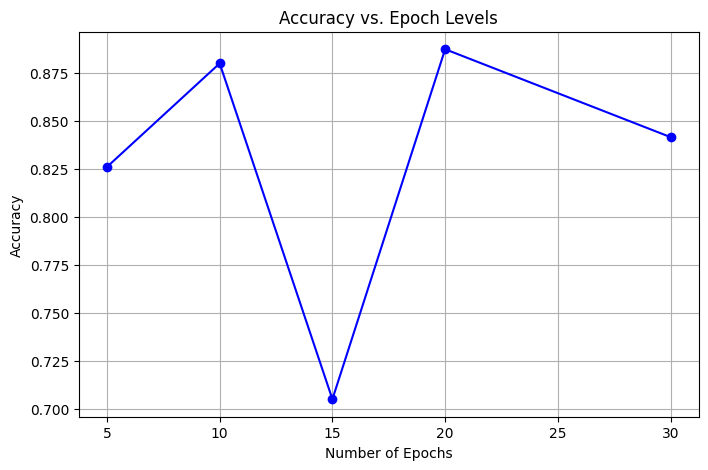

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(epoch_levels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Epoch Levels')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In the context of neural networks and training machine learning models, a scheduler refers to a method for adjusting the learning rate dynamically during the training process. The learning rate dictates how much the model weights are updated during each step of optimization. A scheduler modifies this rate over epochs or iterations to improve training efficiency and model performance


Improved Convergence:

Adapting the learning rate helps the model converge faster and more effectively.

Escaping Local Minima:

High initial learning rates can help the model escape shallow local minima early in training.\

Risk of Premature Learning Rate Decay
Problem: If the learning rate is reduced too early, the model may converge to a suboptimal solution or even stall in a local minimum.
Impact: Can lead to underfitting because the updates become too small to make significant progress.
3. Sensitivity to Noisy Metrics
Problem: For schedulers that rely on performance metrics (e.g., ReduceLROnPlateau), fluctuations in the validation loss due to noise can trigger unnecessary learning rate changes.
Impact: This can destabilize training or lead to inefficiency by decreasing the learning rate unnecessarily.

In [27]:
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn

train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

input_dim = train_combined_tensor.shape[1]
model = FakeNewsClassifier(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

epoch_levels = [5, 10, 15, 20, 30]
accuracy_values = []
learning_rate_values = []

for epochs in epoch_levels:
    # Initialize model and optimizer only once outside the loop
    model = FakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            outputs = model(x_batch).squeeze() 
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        scheduler.step() 

    # Store learning rate after training for the current epoch level
    learning_rate_values.append(scheduler.get_last_lr()[0])
    
    # Evaluate accuracy
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch).squeeze()
            predictions = (outputs > 0.5).float()  # Convert to binary predictions
            y_true.extend(y_batch.tolist())
            y_pred.extend(predictions.tolist())
    
    # Calculate accuracy
    accuracy = sum([1 if y_t == y_p else 0 for y_t, y_p in zip(y_true, y_pred)]) / len(y_true)
    accuracy_values.append(accuracy)


Scheduler: 0.89
Weight Decay: 0.81
Ealry Stopping: 0.84


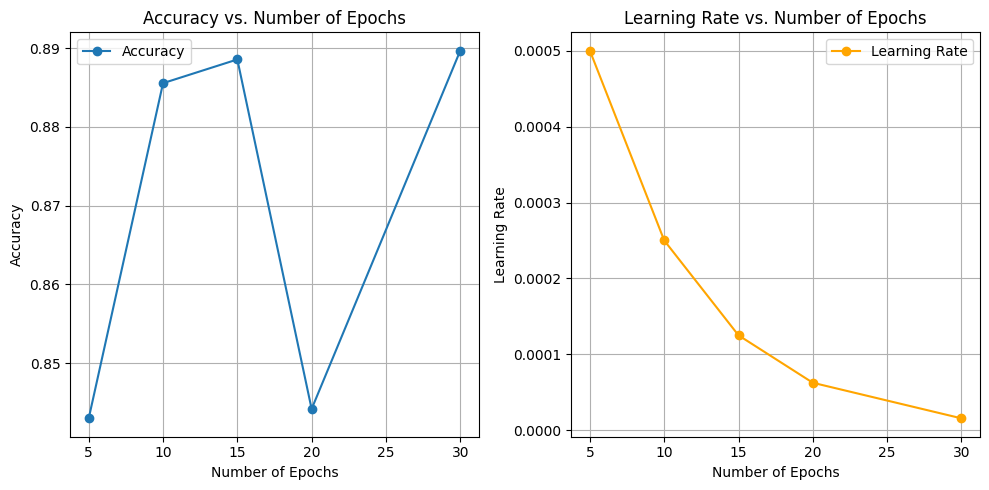

In [29]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_levels, accuracy_values, marker='o', label="Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Epochs")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_levels, learning_rate_values, marker='o', label="Learning Rate", color="orange")
plt.xlabel("Number of Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs. Number of Epochs")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class ComplexFakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ComplexFakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(128,64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

# Initialize the model
input_dim = train_combined_tensor.shape[1]
model = ComplexFakeNewsClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)

# Train the model
epoch_levels = 20
weight_decay_values =  [1e-5, 1e-4,1e-3,1e-2,0.1]
accuracy_values = []



for weight_decay_value in weight_decay_values :
    model = ComplexFakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=weight_decay_value)
    for epoch in range(epoch_levels):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    accuracy = accuracy_score(model, test_loader)
    accuracy_values.append(accuracy)



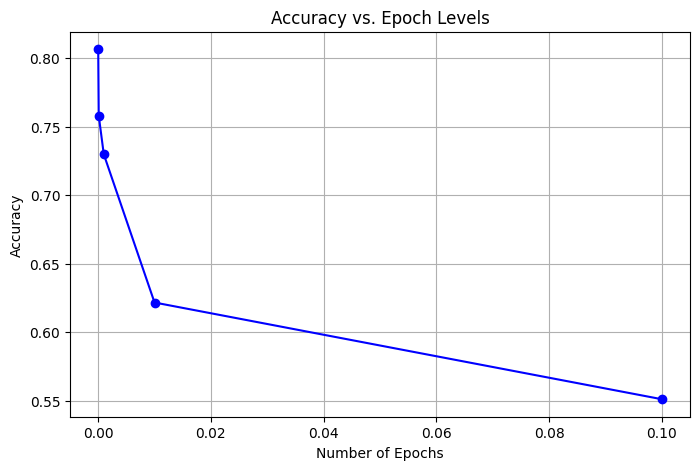

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(weight_decay_values, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Epoch Levels')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Early stopping after 19 epochs. No improvement in accuracy.
Early stopping after 1 epochs. No improvement in accuracy.
Early stopping after 1 epochs. No improvement in accuracy.
Early stopping after 1 epochs. No improvement in accuracy.
Early stopping after 1 epochs. No improvement in accuracy.


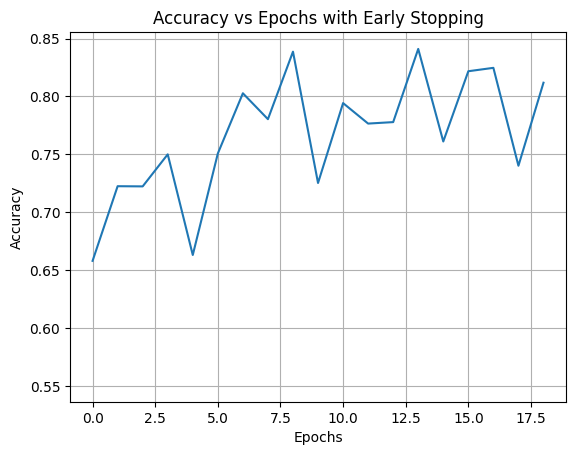

In [33]:
import matplotlib.pyplot as plt

train_dataset = TensorDataset(train_combined_tensor, y_train_tensor)
test_dataset = TensorDataset(test_combined_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class ComplexFakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ComplexFakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

# Initialize the model
input_dim = train_combined_tensor.shape[1]
model = ComplexFakeNewsClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_accuracy = 0.0
epochs_since_improvement = 0

# Train the model
epoch_levels = 20
weight_decay_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]
accuracy_values = []

for weight_decay_value in weight_decay_values:
    model = ComplexFakeNewsClassifier(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay_value)
    
    accuracy_per_epoch = []  # List to store accuracy for each epoch
    for epoch in range(epoch_levels):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        accuracy = accuracy_score(model, test_loader)
        accuracy_values.append(accuracy)
        accuracy_per_epoch.append(accuracy)
        
        # Early stopping: check if accuracy improves
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        # If no improvement for 'patience' epochs, stop training
        if epochs_since_improvement >= patience:
            print(f"Early stopping after {epoch + 1} epochs. No improvement in accuracy.")
            break
    
    # Plotting the accuracy for this weight_decay_value
    plt.plot(range(len(accuracy_per_epoch)), accuracy_per_epoch, label=f'Weight Decay {weight_decay_value}')
    
# Customize the plot
plt.title('Accuracy vs Epochs with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.grid(True)
plt.show()
